Link to the original data: https://www.kaggle.com/jameslko/gun-violence-data

We were interested in investigating gun violence in aggregate across the United States, as the issue is important and relevant, but often discussed on a case-by-case basis rather than holistically. The data standardizes incident reports including information related to the types of guns used, people involved, and locations incidents occur. Some of what we discovered was that certain cities like Chicago have significantly more gun violence than other cities, handguns pose more of a problem than assualt rifles with regards to the number of people killed, and that some seasons are more deadly than others.

In [30]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.formula.api as smf

data = pd.read_csv('gunViolenceData.csv')

# Since an incident_id uniquely identifies a row, we can use it as an index
data.set_index('incident_id', drop = True, inplace=True)

# Remove irrelevant columns
data.drop([
            'address','incident_url','source_url',
            'participant_name','sources','state_house_district',
            'state_senate_district','incident_url_fields_missing',
            'congressional_district','latitude','longitude'], axis=1, inplace=True)

## What is the average number of people killed and injured in a typical incident?

In [31]:
print('Average number of injuries:', round(data['n_injured'].mean(), 2))
print('Average number of killed:', round(data['n_killed'].mean(), 2))

Average number of injuries: 0.49
Average number of killed: 0.25


## Based on the number of deaths and injuries, what's more deadly, an assault rifle or a handgun?

In [32]:
# Classify weapons
handguns = ['Handgun', '9mm', 'Auto', '40 SW', 'Mag',
            '38 Spl', '10mm']
assault_rifles = ['AR-15', 'AK-47']
all_rifles = ['22 LR', '308 Win', '30-30 Win', 'Rifle', '300 Win', '30-06 Spr', 'AR-15', 'AK-47' ]
shotguns = ['Shotgun', 'gauge']

handgun_list = []
assault_rifle_list = []
all_rifle_list = []
shotgun_list = []

# Create handguns column
for i in data['gun_type']:
    guncount = 0
    for j in handguns:
        guncount += str(i).count(j)
    handgun_list.append(guncount)

data['handguns_used'] = handgun_list

# Create assault_rifles column
for i in data['gun_type']:
    guncount = 0
    for j in assault_rifles:
        guncount += str(i).count(j)
    assault_rifle_list.append(guncount)

data['assault_rifles_used'] = assault_rifle_list

# Create all_rifles column
for i in data['gun_type']:
    guncount = 0
    for j in all_rifles:
        guncount += str(i).count(j)
    all_rifle_list.append(guncount)

data['all_rifles_used'] = all_rifle_list

# Create shotgun column
for i in data['gun_type']:
    guncount = 0
    for j in shotguns:
        guncount += str(i).count(j)
    shotgun_list.append(guncount)

data['shotguns_used'] = shotgun_list

data

,date,state,city_or_county,n_killed,n_injured,gun_stolen,gun_type,incident_characteristics,location_description,n_guns_involved,...,participant_age,participant_age_group,participant_gender,participant_relationship,participant_status,participant_type,handguns_used,assault_rifles_used,all_rifles_used,shotguns_used
incident_id,,,,,,,,,,,,,,,,,,,,,
461105,2013-01-01,Pennsylvania,Mckeesport,0,4,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,NaN,NaN,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,0,0,0,0
460726,2013-01-01,California,Hawthorne,1,3,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",NaN,NaN,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,0,0,0,0
478855,2013-01-01,Ohio,Lorain,1,3,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",Cotton Club,2.0,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,0,0,0,0
478925,2013-01-05,Colorado,Aurora,4,0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",NaN,NaN,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,0,0,0,0
478959,2013-01-07,North Carolina,Greensboro,2,2,0::Unknown||1::Unknown,0::Handgun||1::Handgun,"Shot - Wounded/Injured||Shot - Dead (murder, a...",NaN,2.0,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,2,0,0,0
478948,2013-01-07,Oklahoma,Tulsa,4,0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Hom...",Fairmont Terrace,NaN,...,0::23||1::23||2::33||3::55,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Female||2::Female||3::Female||4:...,NaN,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,0,0,0,0
479363,2013-01-19,New Mexico,Albuquerque,5,0,0::Unknown||1::Unknown,0::22 LR||1::223 Rem [AR-15],"Shot - Dead (murder, accidental, suicide)||Mas...",NaN,2.0,...,0::51||1::40||2::9||3::5||4::2||5::15,0::Adult 18+||1::Adult 18+||2::Child 0-11||3::...,0::Male||1::Female||2::Male||3::Female||4::Fem...,5::Family,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,0,1,2,0
479374,2013-01-21,Louisiana,New Orleans,0,5,NaN,NaN,Shot - Wounded/Injured||Drive-by (car to stree...,NaN,NaN,...,NaN,NaN,0::Male||1::Male||2::Male||3::Male||4::Male,NaN,0::Injured||1::Injured||2::Injured||3::Injured...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,0,0,0,0
479389,2013-01-21,California,Brentwood,0,4,NaN,NaN,Shot - Wounded/Injured||Drive-by (car to stree...,NaN,NaN,...,NaN,0::Teen 12-17||1::Teen 12-17||2::Teen 12-17||4...,0::Male||1::Male||2::Male||3::Male||4::Male,NaN,0::Injured||1::Injured||2::Injured||3::Injured...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,0,0,0,0


In [33]:
# Create dataframe for weapons percentages.
# The info below uses the subset of data for which weapons information is available.
weapons_data = data.dropna(subset = ['gun_type']).loc[(data['gun_type'].str.find('0::Unknown') == -1)]

# Classify weapons percentages
handgun_percent = int(((len(weapons_data.loc[weapons_data['handguns_used'] != 0]))/(len(weapons_data)))*100)
rifle_percent = int(((len(weapons_data.loc[weapons_data['all_rifles_used'] != 0]))/(len(weapons_data)))*100)
shotgun_percent = int(((len(weapons_data.loc[weapons_data['shotguns_used'] != 0]))/(len(weapons_data)))*100)

print('Average number of deaths when handgun is used:',
     round(weapons_data.loc[weapons_data['handguns_used'] != 0]['n_killed'].mean(), 2))
print('Average number of injured when handgun is used:',
     round(weapons_data.loc[weapons_data['handguns_used'] != 0]['n_injured'].mean(), 2))
print('Percentage of incidents involving handgun: ',
      handgun_percent, '%', sep = '')

print('\n')

print('Average number of deaths when rifle is used:',
     round(weapons_data.loc[weapons_data['all_rifles_used'] != 0]['n_killed'].mean(), 2))
print('Average number of injured when rifle is used:',
     round(weapons_data.loc[weapons_data['all_rifles_used'] != 0]['n_injured'].mean(), 2))
print('Percentage of incidents involving rifle: ',
      rifle_percent, '%', sep = '')

print('\n')

print('Average number of deaths when Shotgun is used:',
     round(weapons_data.loc[weapons_data['shotguns_used'] != 0]['n_killed'].mean(), 2))
print('Average number of injured when rifle is used:',
     round(weapons_data.loc[weapons_data['shotguns_used'] != 0]['n_injured'].mean(), 2))
print('Fraction of incidents involving rifle: ',
      shotgun_percent, '%', sep = '')

Average number of deaths when handgun is used: 0.14
Average number of injured when handgun is used: 0.23
Percentage of incidents involving handgun: 77%


Average number of deaths when rifle is used: 0.18
Average number of injured when rifle is used: 0.25
Percentage of incidents involving rifle: 19%


Average number of deaths when Shotgun is used: 0.17
Average number of injured when rifle is used: 0.24
Fraction of incidents involving rifle: 11%


Text(0, 0.5, 'Percentage of Incidents')

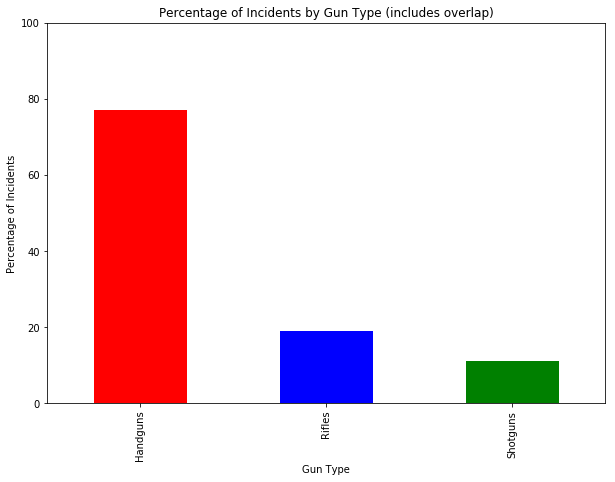

In [34]:
weapons_percentage = {'Gun Type': ['Handguns', 'Rifles', 'Shotguns'], 
                      'Percentage of Incidents': [handgun_percent, rifle_percent, shotgun_percent]}

weapons_chart = pd.DataFrame(weapons_percentage).set_index('Gun Type')

fig, ax = plt.subplots()
weapons_chart.plot.bar(ax=ax, figsize = (10,7), ylim = (0,100), color = ('r','b','g'), legend = False)
ax.set_title('Percentage of Incidents by Gun Type (includes overlap)')
ax.set_ylabel('Percentage of Incidents')

## Which states have the most gun violence?

The below shows the five states with the largest number of gun violence incidents. Illinois in particular leads the pack.

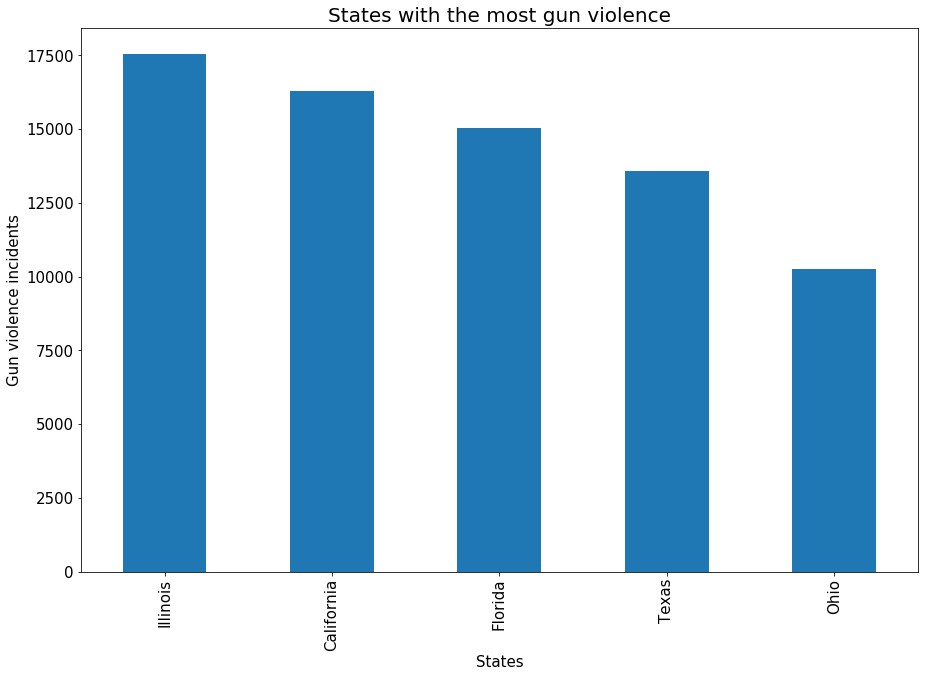

In [35]:
fig1,ax1 = plt.subplots()
ax1.set_title('States with the most gun violence', size = 20)
ax1.set_xlabel('States', size=15)
ax1.set_ylabel('Gun violence incidents', size=15)
ax1.tick_params(axis='both', labelsize=15)

data['state'].value_counts().head().plot.bar(ax = ax1, figsize = (15,10))

## Which cities have the most gun violence?

We can see below that Chicago has the most reported incidents, likely driving Illinois to the top of the back above. Interestingly, the next most violent states do not line up with the next most violent cities. One further area of exploration could be to investigate what leads to diffusion or concentration of gun violence across states.

Percentage of gun violence incidents that occur in Chicago: 4.51%


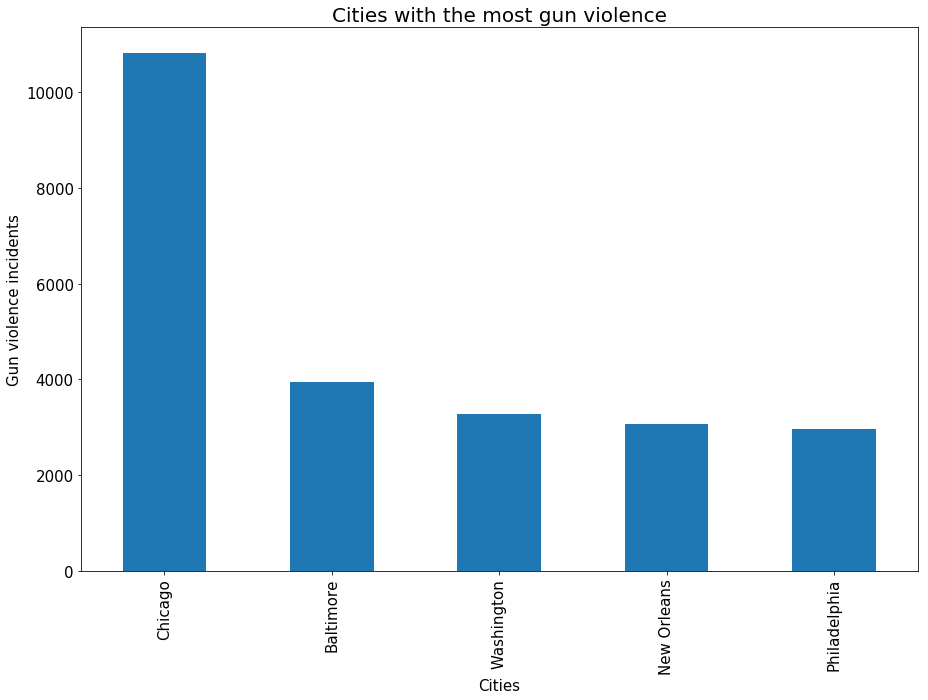

In [36]:
fig2,ax2 = plt.subplots()
ax2.set_title('Cities with the most gun violence', size = 20)
ax2.set_xlabel('Cities', size=15)
ax2.set_ylabel('Gun violence incidents', size=15)
ax2.tick_params(axis='both', labelsize=15)

data['city_or_county'].value_counts().head().plot.bar(ax = ax2, figsize= (15,10))

#Follow up: What percentage of gun violence incidents occur in Chicago?
numerator = len(data.loc[data['city_or_county'] == 'Chicago'].index)
denominator = len(data)

percent = (numerator/denominator) * 100

print('Percentage of gun violence incidents that occur in Chicago: ' + str(np.round(percent, decimals = 2)) + '%') 

## Which cities have the most deaths from gun violence? Injuries?

One question we have is whether incidents of gun violence necessarily correlate strongly with injuries and deaths. The common-sense answer is yes, but is it one-to-one?

Text(0.5, 0, 'Cities')

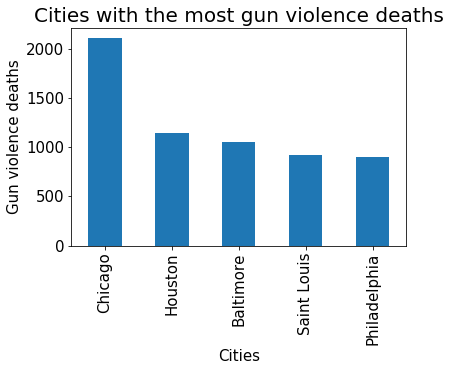

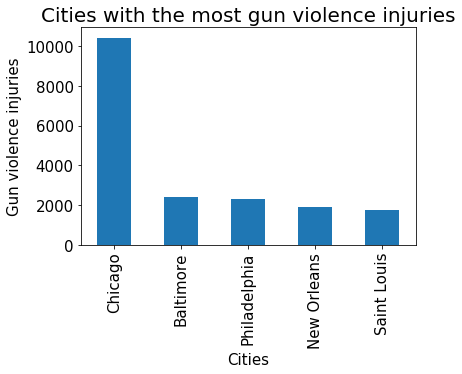

In [37]:
figMostKilledCities, axMostKilledCities = plt.subplots()
axMostKilledCities.set_title('Cities with the most gun violence deaths', size = 20)
axMostKilledCities.set_ylabel('Gun violence deaths', size=15)
axMostKilledCities.tick_params(axis='both', labelsize=15)

figMostInjuredCities,axMostInjuredCities = plt.subplots()
axMostInjuredCities.set_title('Cities with the most gun violence injuries', size = 20)
axMostInjuredCities.set_ylabel('Gun violence injuries', size=15)
axMostInjuredCities.tick_params(axis='both', labelsize=15)

casualtyData = data.groupby('city_or_county').sum()

killedData = casualtyData.sort_values(by='n_killed', ascending=False)['n_killed']
injuredData = casualtyData.sort_values(by='n_injured', ascending=False)['n_injured']

killedData.head().plot.bar(ax = axMostKilledCities)
injuredData.head().plot.bar(ax = axMostInjuredCities)

axMostInjuredCities.set_xlabel('Cities', size=15)
axMostKilledCities.set_xlabel('Cities', size=15)

It looks like incidents/injuries/deaths are all correlated, which we show below. A naive conclusion here would be that all gun use is associated with injury and death, but it's important to remember that these are correlations conditional on the incident having been reported to the police. So to make that point fully we'd have to compare gun incidents not reported to police (and probably then expand our definition of "incident") to see if the pattern holds across all gun use.

In [38]:
data.groupby('city_or_county').agg({'city_or_county':'count','n_injured':'sum','n_killed':'sum'}).corr()

,city_or_county,n_injured,n_killed
city_or_county,1.000000,0.957966,0.942140
n_injured,0.957966,1.000000,0.890021
n_killed,0.942140,0.890021,1.000000


## What is the ratio of women to men participants in gun violence?

For every woman involved in a gun violence incident, there are 7.16 men.

Text(0, 0.5, '')

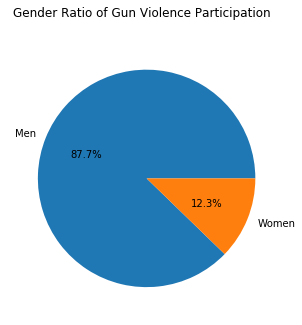

In [39]:
figGender, axGender = plt.subplots()
participantGenderList = data['participant_gender']
participantGenderList.dropna(inplace=True)

maleCount = 0
femaleCount = 0
for i in participantGenderList:
    femaleCount += i.count('Female')
    maleCount += i.count('Male')

ratio = maleCount/femaleCount
genderRatioDf = pd.DataFrame([np.round(ratio, decimals = 2),1], index=['Men', 'Women'])
genderRatioDf.plot.pie(subplots=True, 
                       title ='Gender Ratio of Gun Violence Participation', 
                       legend = False, 
                       autopct ='%1.1f%%',
                       ax = axGender)
figGender.set_size_inches(5,5)
axGender.set_ylabel('')

## Which cities are seeing the largest increase/decrease in gun violence deaths?

We now want to think about gun violence as a time series, it changes rather than levels.

Based on the below findings, it looks like most of the cities that have the largest increases in gun violence deaths are situated in the southeastern/midwestern area. Most of these cities have either no increase in population, or a slight increase in population.

The cities with the largest decreases in population have little to no change in population size and are located in either the northeast or California.

C:\Users\romne\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


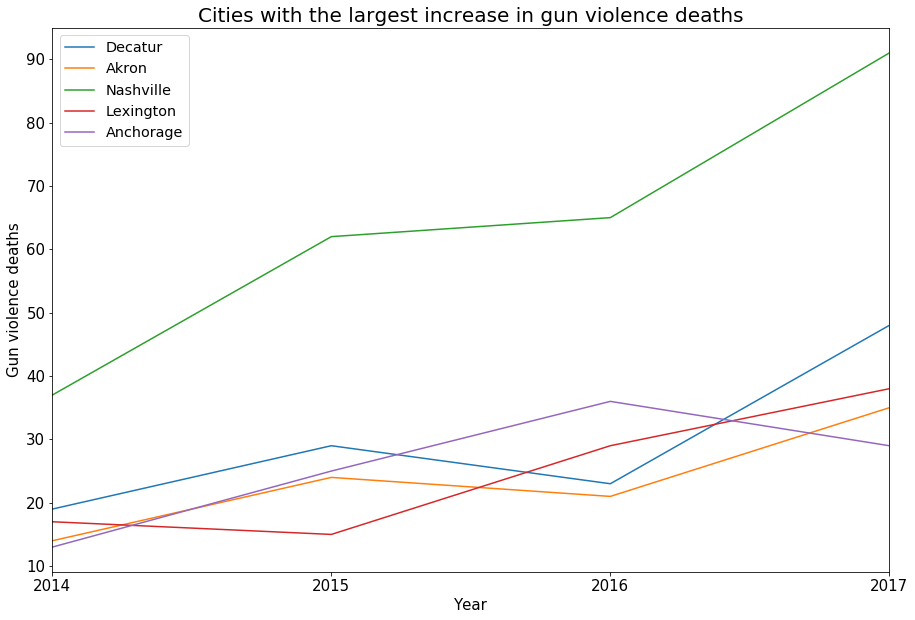

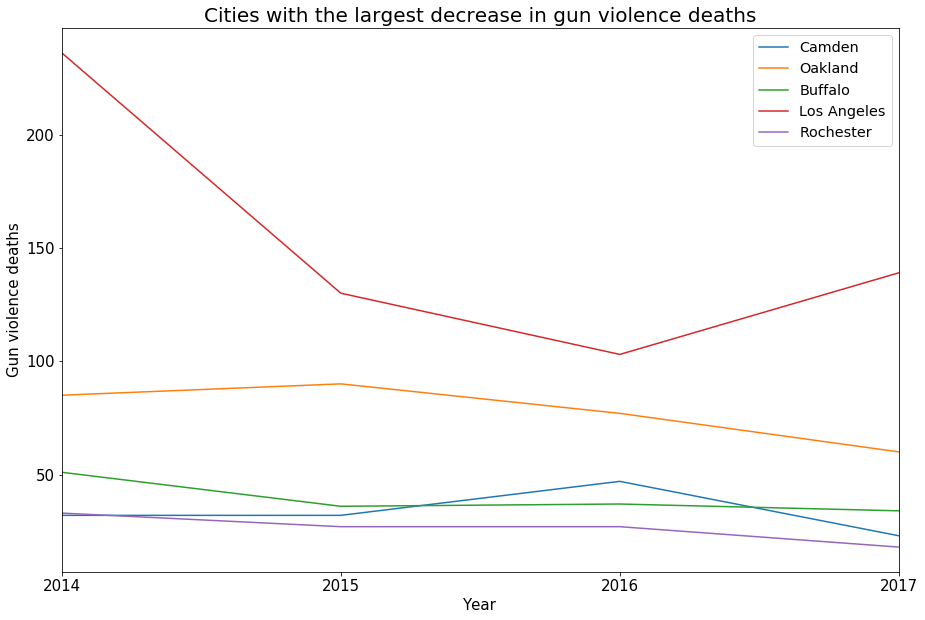

In [40]:
#Only consider the cities that have had over 100 gun violence deaths total
killedData > 100

citiesToConsider = killedData[killedData > 100]
citiesToConsider = citiesToConsider.index.tolist()

dataWithFilteredCities = data.loc[data['city_or_county'].isin(citiesToConsider)]
dataWithFilteredCities['year'] = pd.to_numeric(dataWithFilteredCities['date'].str[:4])
dataWithFilteredCities = dataWithFilteredCities.loc[~dataWithFilteredCities['year'].isin([2013,2018])]
dataWithFilteredCities = dataWithFilteredCities.groupby(['year','city_or_county']).sum()

#For each city, look at the differences in death totals between 2014 and 2017.
# 2014 and 2017 are the first and last full years of data, and that's why they're chosen
# (Since 2013 and 2018 have relatively few gun incident entries)
percentageDifferenceInDeaths = []
 
for i in citiesToConsider:
    query2014 = 'year == 2014 and city_or_county == "'+ i +'"'
    query2017 = 'year == 2017 and city_or_county == "'+ i +'"'
    numKilled2014 = dataWithFilteredCities.query(query2014)['n_killed'].tolist()
    numKilled2017 = dataWithFilteredCities.query(query2017)['n_killed'].tolist()
    #Only include cities that have values for the number of people killed in 2014/2017
    if len(numKilled2014) & len(numKilled2017):
        if numKilled2014[0]:
            #Add the percentage differences in the number of people killed to an array
            percentDiff = np.round(100 * (numKilled2017[0] - numKilled2014[0])/numKilled2014[0], decimals = 2)  
            percentageDifferenceInDeaths.append([i, percentDiff])
    
percentDiffDf = pd.DataFrame(percentageDifferenceInDeaths , columns=['city', 'percentDiff'])

percentDiffDf.sort_values(by='percentDiff', ascending = False, inplace = True)
citiesWithMostIncrease = percentDiffDf.head()['city'].tolist()
citiesWithMostDecrease = percentDiffDf.tail()['city'].tolist()

figIncreasedCities,axIncreasedCities = plt.subplots()
axIncreasedCities.set_title('Cities with the largest increase in gun violence deaths', size = 20)
axIncreasedCities.set_ylabel('Gun violence deaths', size=15)
axIncreasedCities.tick_params(axis='both', labelsize=15)

figDecreasedCities,axDecreasedCities = plt.subplots()
axDecreasedCities.set_title('Cities with the largest decrease in gun violence deaths', size = 20)
axDecreasedCities.set_ylabel('Gun violence deaths', size=15)

axDecreasedCities.tick_params(axis='both', labelsize=15)

for i in citiesWithMostIncrease:
    display(dataWithFilteredCities.query('city_or_county == "' + i + '"')['n_killed'].plot(ax = axIncreasedCities, 
                                                                                           figsize=(15,10), 
                                                                                           legend = True, 
                                                                                           label = i))
for i in citiesWithMostDecrease:
    display(dataWithFilteredCities.query('city_or_county == "' + i + '"')['n_killed'].plot(ax = axDecreasedCities,
                                                                                           figsize=(15,10),
                                                                                           legend = True,
                                                                                           label = i))
# Set the x-ticks appropriately
xtickYears = ['2014','2015','2016','2017']
xtickPositions = np.array([0,1,2,3])
axIncreasedCities.set_xticks(xtickPositions)
axDecreasedCities.set_xticks(xtickPositions)
axIncreasedCities.set_xticklabels(xtickYears)
axDecreasedCities.set_xticklabels(xtickYears)
axIncreasedCities.set_xlabel('Year', size=15)    
axDecreasedCities.set_xlabel('Year', size=15)

axIncreasedCities.legend(fontsize='x-large')
axDecreasedCities.legend(fontsize='x-large')

## What percentage of total deaths occur in the most dangerous cities?

In [41]:
cities = data.groupby('city_or_county', as_index = False).agg(
    {'date':'count', 'n_killed':'sum'}).sort_values(
    by = 'n_killed', ascending = False).rename(columns = {'date':'incidents'}).set_index('city_or_county')

cities['percentage of total killed'] = np.round(cities['n_killed']/(len(data))*100, decimals = 2)

cities.iloc[:10,:]

,incidents,n_killed,percentage of total killed
city_or_county,,,
Chicago,10814,2104,0.88
Houston,2501,1145,0.48
Baltimore,3943,1055,0.44
Saint Louis,2501,919,0.38
Philadelphia,2963,901,0.38
New Orleans,3071,703,0.29
Los Angeles,1066,636,0.27
Memphis,2386,623,0.26
Indianapolis,1920,616,0.26


## What is the average participant age?

The average age of participants is: 29.46


Text(0.5, 1.0, 'Participant Age in Gun Violence')

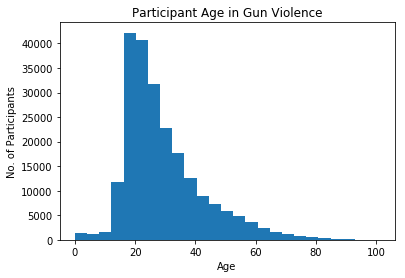

In [42]:
figAge, axAge = plt.subplots()

totalAge = 0
totalParticipants = 0
ageArray = []
#This method takes in a string list 
# (for example, the string from participant_age_group: '0::Adult 18+||1::Adult 18+||2::Adult 18+||3::Adult 18+||4::Adult 18+'
#  returns a list ['Adult 18+', 'Adult 18+', 'Adult 18+', 'Adult 18+', 'Adult 18+'])
def convertStringList(givenStr):    
    #Some strings are formatted incorrectly: with only one ':' and '|'. Ex: 0:47|1:34|2:34
    isIncorrectMultiple = (givenStr.count('||') == 0) & (givenStr.count('|') > 0)
    isIncorrectSingle = (givenStr.count(':') == 1) & (givenStr.count('|') == 0)

    if isIncorrectSingle or isIncorrectMultiple:
        givenStr = givenStr.replace(':','::')
        givenStr = givenStr.replace('|','||')
    
    constructedList = givenStr.split('||')
    for i in range(0, len(constructedList)):
        strToReplace = constructedList[i]
        index = strToReplace.index('::') + 2
        constructedList[i] = strToReplace[index:]
    
    return constructedList

for i in data['participant_age']:
    if pd.isnull(i) == False:
        ageList = convertStringList(i)
        totalParticipants += len(ageList)
        for j in ageList:
            #There are invalid dates in the data (possibly incorrect entries typed in)
            #Adjust the code in these cases
            if int(j) > 110:
                totalParticipants-=1
            else:    
                totalAge += int(j) 
                ageArray.append(int(j))

averageAge = np.round(totalAge / totalParticipants, decimals = 2)
print('The average age of participants is: ' + str(averageAge))

plt.hist(x=ageArray, bins = 25)
plt.xlabel('Age')
plt.ylabel('No. of Participants')
plt.title('Participant Age in Gun Violence')

## Let's take a monthly look at Manhattan violence, and Chicago violence.

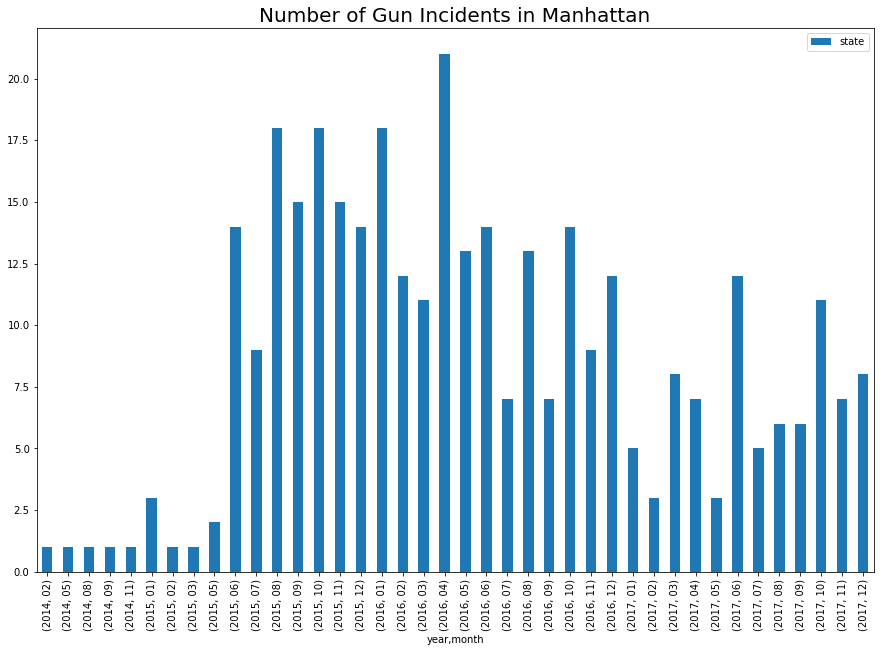

In [43]:
data['year'] = data['date'].str[0:4]
data['month'] = data['date'].str[5:7]
drange = ["2014","2015","2016","2017"]

d1 = data.reset_index()
fig,ax = plt.subplots()
ax.set_title('Number of Gun Incidents in Manhattan', size=20)
d1.loc[(d1['city_or_county']=='New York (Manhattan)')&(d1['year'].isin(drange))].groupby(['year','month']).agg({'state':'count'}).plot.bar(ax=ax, figsize=(15,10))

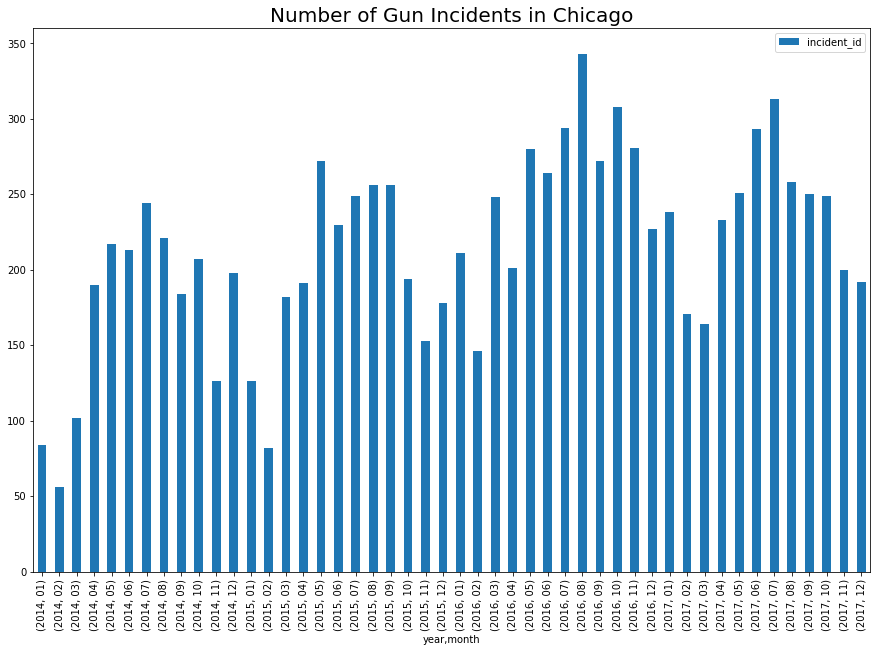

In [44]:
drange = ["2014","2015","2016","2017"]
fig,ax = plt.subplots()
ax.set_title('Number of Gun Incidents in Chicago', size=20)
d1.loc[(d1['city_or_county']=='Chicago')&(d1['year'].isin(drange))].groupby(['year','month']).agg({'incident_id':'count'}).plot.bar(ax=ax, figsize=(15,10))

While violence in Chicago exceeds violence in Manhattan, we can see a sort of oscillating pattern in the data for both cities. We've all heard the phrase that gun violence correlates with ice cream sales (the latent variable being heat - let's run a regression to test this. We create dummy variables per quarter and assume for now that Q2 and Q3 are the "summer" quarters while Q1 and Q4 are the "winter" quarters, and aggregate across quarters.

In [45]:
conditions = [
    (d1['month'].str.contains('01'))|(d1['month'].str.contains('02'))|(d1['month'].str.contains('03')),
    (d1['month'].str.contains('04'))|(d1['month'].str.contains('05'))|(d1['month'].str.contains('06')),
    (d1['month'].str.contains('07'))|(d1['month'].str.contains('08'))|(d1['month'].str.contains('09')),
    (d1['month'].str.contains('10'))|(d1['month'].str.contains('11'))|(d1['month'].str.contains('12')),
]

choices=['q1','q2','q3','q4']
d1['quarter'] = np.select(conditions,choices,default='missing')

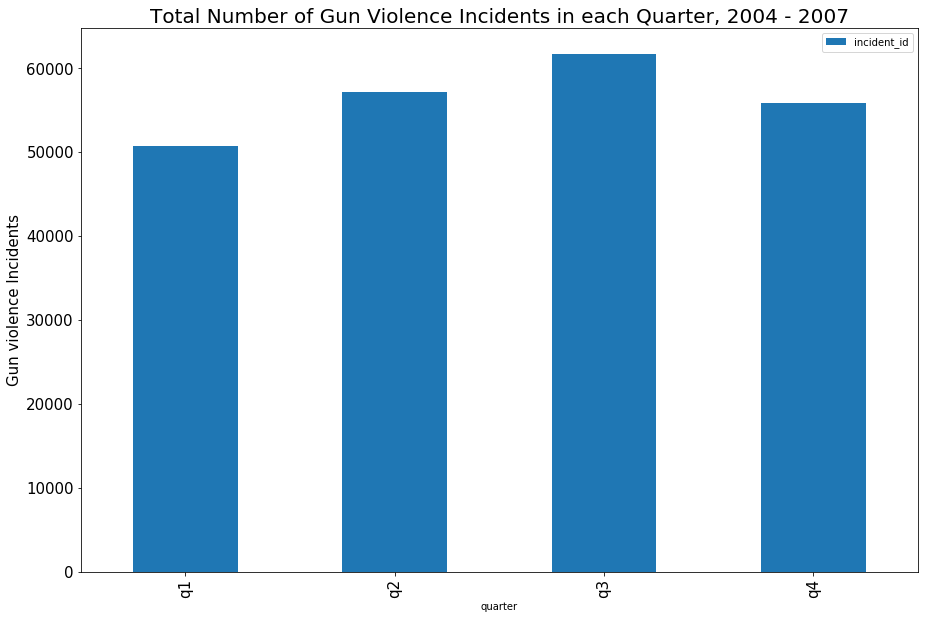

In [46]:
drange = ["2014","2015","2016","2017"]
fig,ax = plt.subplots()
ax.set_title("Total Number of Gun Violence Incidents in each Quarter, 2004 - 2007", size = 20)
ax.set_ylabel('Gun violence Incidents', size=15)
ax.tick_params(axis='both', labelsize=15)
d1.loc[(d1['year'].isin(drange))].groupby('quarter').agg({'incident_id':'count'}).plot.bar(ax=ax, figsize=(15,10))

We already know that gun incidents correlate with violence and deaths, but let's check if this holds up across "seasons":

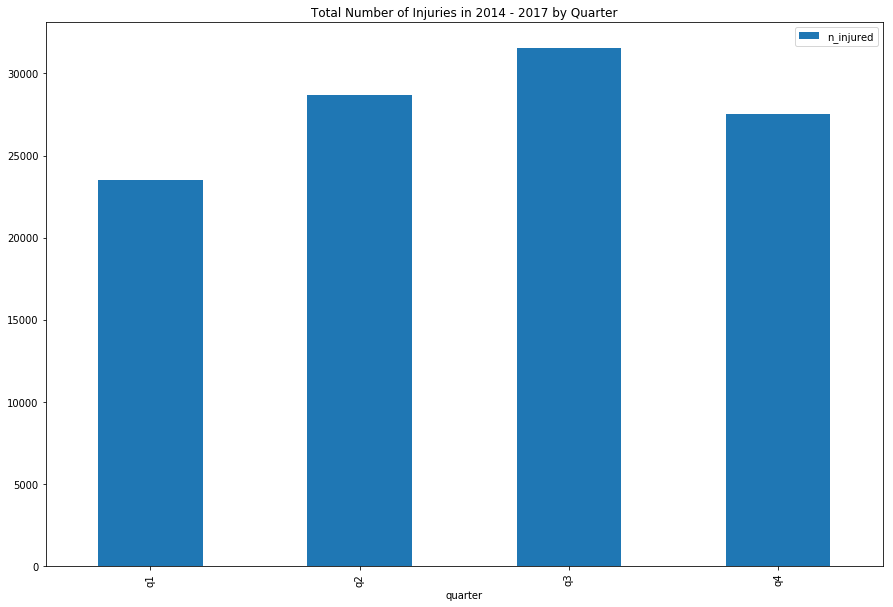

In [47]:
drange = ["2014","2015","2016","2017"]
fig,ax = plt.subplots()
ax.set_title("Total Number of Injuries in 2014 - 2017 by Quarter")
d1.loc[(d1['year'].isin(drange))].groupby('quarter').agg({'n_injured':'sum'}).plot.bar(ax=ax, figsize=(15,10))

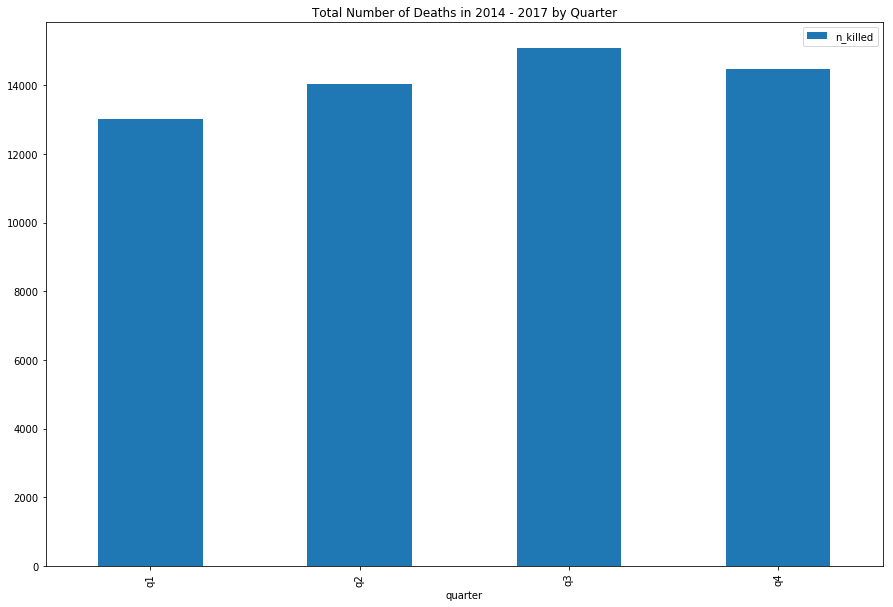

In [48]:
drange = ["2014","2015","2016","2017"]
fig,ax = plt.subplots()
ax.set_title("Total Number of Deaths in 2014 - 2017 by Quarter")
d1.loc[(d1['year'].isin(drange))].groupby('quarter').agg({'n_killed':'sum'}).plot.bar(ax=ax, figsize=(15,10))

Let's use a regression to see if there is a statistically significant effect of entering summer months on the likelihood of gun incidents.

In [54]:
d1['dt'] = d1['year'] + '-' + d1['month'] + '-01'
d2 = d1.loc[(d1['year'].isin(drange))].groupby(['city_or_county','dt']).agg({'incident_id':'count'})
d2.reset_index(inplace=True)

In [55]:
d2['month'] = d2.reset_index()['dt'].str[5:7]
d2.columns

Index(['city_or_county', 'dt', 'incident_id', 'month'], dtype='object')

In [56]:
d2['q1'] = (d2['month'] == '01')|(d2['month'] == '02')|(d2['month'] == '03')
d2['q2'] = (d2['month'] == '04')|(d2['month'] == '05')|(d2['month'] == '06')
d2['q3'] = (d2['month'] == '07')|(d2['month'] == '08')|(d2['month'] == '09')
d2.set_index(['city_or_county',pd.DatetimeIndex(d2['dt'])],inplace=True)

In [57]:
reg = smf.ols('incident_id ~ q1 + q2 + q3', data=d2).fit()

In [58]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            incident_id   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.523
Date:                Tue, 09 Jul 2019   Prob (F-statistic):           4.98e-05
Time:                        22:41:57   Log-Likelihood:            -2.4967e+05
No. Observations:               69122   AIC:                         4.994e+05
Df Residuals:                   69118   BIC:                         4.994e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1950      0.068     47.149      0.000       3.062       3.328
q1[T.True]    -0.1674      0.097     -1.728      0.084      -0.357       0.022
q2[T.True]     0.1853      0.097      1.917      0.055      -0.004       0.375
q3[T.True]     0.2464      0.095      2.587      0.010       0.060       0.433
==============================================================================
Omnibus:                   131467.104   Durbin-Watson:                   0.155
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        351423899.575
Skew:                          14.673   Prob(JB):                         0.00
Kurtosis:                     351.077   Cond. No.                         4.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is not an impressive r^2, which isn't surprising. Let's see if we can control for heterogeneity across cities/counties by de-meaning the LHS variable (note: Python has dropped the PanelOLS method as of Version 3. We're estimating a loose interpretation of a fixed-effects model here.)

In [59]:
d2.drop('dt',1,inplace=True)

In [60]:
d2.reset_index(inplace=True)
d2['dmy'] = d2['incident_id'] - d2.groupby('city_or_county')['incident_id'].transform('mean')

In [28]:
reg = smf.ols('dmy ~ q1 + q2 + q3', data=d2).fit()

In [61]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            incident_id   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.523
Date:                Tue, 09 Jul 2019   Prob (F-statistic):           4.98e-05
Time:                        22:42:11   Log-Likelihood:            -2.4967e+05
No. Observations:               69122   AIC:                         4.994e+05
Df Residuals:                   69118   BIC:                         4.994e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1950      0.068     47.149      0.000       3.062       3.328
q1[T.True]    -0.1674      0.097     -1.728      0.084      -0.357       0.022
q2[T.True]     0.1853      0.097      1.917      0.055      -0.004       0.375
q3[T.True]     0.2464      0.095      2.587      0.010       0.060       0.433
==============================================================================
Omnibus:                   131467.104   Durbin-Watson:                   0.155
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        351423899.575
Skew:                          14.673   Prob(JB):                         0.00
Kurtosis:                     351.077   Cond. No.                         4.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So that helps a bit. We'd likely have to use other data like micro- and macroeconomic factors that could contribute to violence, or person-specific factors that could contribute to the likelihood of participating in gun violence to get a better fit/r^2 - fundamentally, we don't expect seasonality to explain variation in incidents. But we do see that gun incidents increase in the hotter months. 